In [12]:
from warnings import filterwarnings
filterwarnings('ignore')

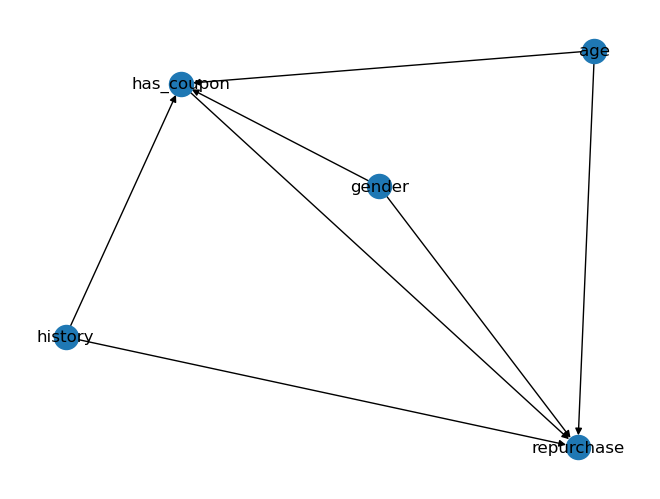

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from([
    ("history", "has_coupon"),
    ("history", "repurchase"),
    ("age", "has_coupon"),
    ("age", "repurchase"),
    ("gender", "has_coupon"),
    ("gender", "repurchase"),
    ("has_coupon", "repurchase"),
])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, arrows=True)
plt.show()


In [13]:
import pandas as pd
import numpy as np

np.random.seed(42)

N = 5000
# 随机生成历史消费（0-20次）、年龄（18-50）、性别（0/1）
df = pd.DataFrame({
    "customer_id": np.arange(N),
    "past_purchase": np.random.randint(0, 21, N),
    "age": np.random.randint(18, 51, N),
    "gender": np.random.choice([0, 1], N)  # 0=男, 1=女
})

# 有经验的运营会优先给高活跃用户发券
df["has_coupon"] = (df["past_purchase"] + np.random.randn(N)*2 > 10).astype(int)

# 复购概率= 基础概率 + 发券提升 + 历史消费影响 + 随机波动
base_prob = 0.2 + 0.02 * df["past_purchase"]
df["repurchase"] = (
    (base_prob + 0.15*df["has_coupon"] + np.random.randn(N)*0.05) > 0.5
).astype(int)


In [21]:
from dowhy import CausalModel
import dowhy

model = CausalModel(
    data=df,
    treatment="has_coupon",
    outcome="repurchase",
    common_causes=["past_purchase", "age", "gender"]
)

identified_estimand = model.identify_effect()

causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

print("Estimated Causal Effect of has_coupon on repurchase:", causal_estimate.value)

# 敏感性/鲁棒性验证
res = model.refute_estimate(
    identified_estimand, causal_estimate, method_name="placebo_treatment_refuter",method_params={"random_seed": 42}
)
print(res)


Estimated Causal Effect of has_coupon on repurchase: 0.5328
Refute: Use a Placebo Treatment
Estimated effect:0.5328
New effect:0.00042
p value:0.98



In [15]:
print(df["has_coupon"].value_counts())

has_coupon
1    2513
0    2487
Name: count, dtype: int64


In [16]:
# 把顾客分成新客和老客
df["is_new_customer"] = (df["past_purchase"] < 9).astype(int)


In [17]:
df.groupby('is_new_customer')['is_new_customer'].value_counts()

is_new_customer
0    2851
1    2149
Name: count, dtype: int64

In [18]:
for group, label in [(1, "新客"), (0, "老客")]:
    sub_df = df[df["is_new_customer"] == group]
    model = CausalModel(
        data=sub_df,
        treatment="has_coupon",
        outcome="repurchase",
        common_causes=["past_purchase", "age", "gender"]
    )
    identified_estimand = model.identify_effect()
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.propensity_score_matching"
    )
    print(f"{label}组，发券提升复购率：{causal_estimate.value:.3f}")


新客组，发券提升复购率：0.122
老客组，发券提升复购率：0.862


In [29]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

# 以你已有的数据 df
features = ["has_coupon", "past_purchase", "age", "gender"]
X = df[features]
y = df["repurchase"]

# 训练一个二分类模型
model = LogisticRegression()
model.fit(X, y)


LogisticRegression()

In [31]:
df_counterfactual_0 = df.copy()
df_counterfactual_0["has_coupon"] = 0
pred_0 = model.predict_proba(df_counterfactual_0[features])[:, 1]

df_counterfactual_1 = df.copy()
df_counterfactual_1["has_coupon"] = 1
pred_1 = model.predict_proba(df_counterfactual_1[features])[:, 1]

print("如果所有人都没发券，平均复购率预期：", pred_0.mean())
print("如果所有人都发券，平均复购率预期：", pred_1.mean())
print("反事实提升：", pred_1.mean() - pred_0.mean())


如果所有人都没发券，平均复购率预期： 0.3123508585866492
如果所有人都发券，平均复购率预期： 0.5917714874730816
反事实提升： 0.27942062888643243


In [45]:
from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor

est = LinearDML(model_y=RandomForestRegressor(), model_t=RandomForestRegressor())
X = df[["past_purchase", "age", "gender"]]
T = df["has_coupon"]
Y = df["repurchase"]
est.fit(Y, T, X=X)

# 预测反事实
te_pred = est.effect(X) # 每个人的个体归因提升
print("个体归因效应均值：", te_pred.mean())

# 如果需要“如果全都发券/全都不发券”场景
y_all1 = est.const_marginal_effect(X) * 1 + est.model_final_.intercept_
y_all0 = est.const_marginal_effect(X) * 0 + est.model_final_.intercept_
print("全员发券预测复购均值：", y_all1.mean())
print("全员不发券预测复购均值：", y_all0.mean())
print("提升：", (y_all1-y_all0).mean())


个体归因效应均值： 0.6943562184862746
全员发券预测复购均值： 0.6943562184862746
全员不发券预测复购均值： 0.0
提升： 0.6943562184862746


In [44]:
est.model_final_.intercept_

In [36]:
est.const_marginal_effect(X)

array([0.53267227, 1.14264813, 0.91117154, ..., 0.94954608, 0.3493215 ,
       0.84709618])

In [47]:
from dowhy import CausalModel
import pandas as pd

# 假设df有所有链路变量
causal_graph = """
digraph {
    activity_type -> exposure;
    exposure -> has_coupon;
    has_coupon -> visit_store;
    visit_store -> repurchase;
    weather -> exposure;
    weather -> visit_store;
    region -> exposure;
    region -> visit_store;
    customer_segment -> has_coupon;
    customer_segment -> repurchase;
}
"""

model = CausalModel(
    data=df,
    treatment="has_coupon",   # 你也可以分析activity_type的因果效应
    outcome="repurchase",
    graph=causal_graph
)


In [53]:
df.head()

,customer_id,past_purchase,age,gender,has_coupon,repurchase,propensity_score,is_new_customer
0,0,6,43,0,0,0,0.023377,1
1,1,19,45,1,1,1,0.999770,0
2,2,14,49,0,0,0,0.977852,0
3,3,10,19,0,0,0,0.512123,0
4,4,7,48,0,0,0,0.057561,1
